## Imports

In [1]:
from constants import ORIGINAL_FLUXES_FILE, \
                      ORIGINAL_SLM_FOLDER, \
                      ORIGINAL_AMPLITUDE_FILENAME, \
                      ORIGINAL_PHASE_FILENAME, \
                      TRAIN_FC_FLUXES_PATH, \
                      TRAIN_FC_AMP_PHASE_PATH, \
                      VALIDATION_FC_FLUXES_PATH, \
                      VALIDATION_FC_AMP_PHASE_PATH

from data_utils import load_numpy_data, normalize_data, flatten_data, fuse_amplitude_and_phase
                    

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_fully_connected_amp_phase_prediction

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           train_model_with_generator, \
                           store_model

import numpy as np

from configurations import SimpleFCModel as ModelConfig

2024-02-07 06:12:38.801377: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 06:12:38.845072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 06:12:38.845102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 06:12:38.846190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 06:12:38.853161: I tensorflow/core/platform/cpu_feature_guar

## Load data

In the first place, define the data paths

In [2]:
train_amp_phase_array = load_numpy_data(ORIGINAL_FLUXES_FILE)

amps = []
phases = []
for i in range(3):
    
    train_amp_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}0{i}/{ORIGINAL_AMPLITUDE_FILENAME}")
    amps.append(train_amp_array)
    train_phase_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}0{i}/{ORIGINAL_PHASE_FILENAME}")
    phases.append(train_phase_array)

train_amp_array = np.concatenate(amps, axis=0)
train_phase_array = np.concatenate(phases, axis=0)

val_amp_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}07/{ORIGINAL_AMPLITUDE_FILENAME}")
val_phase_array = load_numpy_data(f"{ORIGINAL_SLM_FOLDER}07/{ORIGINAL_PHASE_FILENAME}")

In [3]:
train_amp_phase_array, scaler = normalize_data(train_amp_phase_array)

train_amp_array, scaler = normalize_data(train_amp_array)
val_amp_array, scaler = normalize_data(val_amp_array)

train_phase_array, scaler = normalize_data(train_phase_array)
val_phase_array, scaler = normalize_data(val_phase_array)

In [4]:
train_fluxes_array = flatten_data(train_amp_phase_array)[:30000]
validation_fluxes_array = flatten_data(train_amp_phase_array)[70000:80000]

In [5]:
train_amp_phase_array = fuse_amplitude_and_phase(train_amp_array, train_phase_array, axis=1)
validation_amp_phase_array = fuse_amplitude_and_phase(val_amp_array, val_phase_array, axis=1)

In [6]:
validation_fluxes_array = load_numpy_data(VALIDATION_FC_FLUXES_PATH)
validation_amp_phase_array = load_numpy_data(VALIDATION_FC_AMP_PHASE_PATH)

In [7]:
train_fluxes_array

array([[-0.37080115, -0.16028187,  0.00289432, ..., -0.75957   ,
        -0.6927443 , -0.69368632],
       [-0.30093868, -0.08703896,  0.0738836 , ..., -0.87112459,
        -0.80429889, -0.79059232],
       [-0.2705147 , -0.03295188,  0.1538874 , ..., -0.90267538,
        -0.83923012, -0.8210163 ],
       ...,
       [-0.83504851, -0.78679045, -0.76559283, ..., -0.83732017,
        -0.88092224, -0.88749832],
       [-0.85195072, -0.80256585, -0.73629566, ..., -0.66829807,
        -0.74345093, -0.80636772],
       [-0.83166807, -0.77326868, -0.66530638, ..., -0.10263744,
        -0.18342437, -0.32634495]])

In [8]:
validation_fluxes_array

array([[-0.8620921 , -0.78341   , -0.7261543 , ..., -0.11953966,
        -0.19919977, -0.3376131 ],
       [-0.5679936 , -0.24028566,  0.16628236, ..., -0.7674577 ,
        -0.80767936, -0.8548207 ],
       [-0.8823747 , -0.81834126, -0.7081253 , ...,  0.4235847 ,
         0.38674352,  0.19536993],
       ...,
       [-0.7629324 , -0.64481187, -0.53684956, ..., -0.9218312 ,
        -0.93726295, -0.92806363],
       [-0.7325084 , -0.5253696 , -0.21796122, ..., -0.6615372 ,
        -0.731056  , -0.7883387 ],
       [-0.8733602 , -0.8172144 , -0.74080294, ..., -0.12517372,
        -0.18680482, -0.2891601 ]], dtype=float32)

## Define configuration

In [9]:
model_configuration = ModelConfig()
print(model_configuration.get_description())


	=== FCBNDRL110000Original ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: 1320
		-Output shape: (2, 96, 96)
		-Hidden layers: [2000, 2000, 2000, 2000]
		-Regularizer: None
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: True
		-Dropout: True, 0.2
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.0001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 200
		-Batch size: 64
		-Callbacks: 
			-ReduceLROnPlateau: MSE 15 x0.1
			-Early Stop: MSE 50
	


2024-02-07 06:12:58.493915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 06:12:58.589189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 06:12:58.589586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Instantiate model

In [10]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "FCBNDRL110000Original"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              2640000   
                                                                 
 batch_normalization (Batch  (None, 2000)              8000      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2000)              0         
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              4000000   
                                                                 
 batch_normalization_1 (Bat  (None, 2000)              8000      
 chNormalization)                            

## Compile model

In [11]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

## Train model

In [12]:
validation_amp_phase_array[0].shape

(2, 96, 96)

In [13]:
history = train_model(model, 
                      train_fluxes_array, 
                      train_amp_phase_array, 
                      validation_fluxes_array, 
                      validation_amp_phase_array,
                      *model_configuration.unpack_training_hyperparameters()
                    )


Epoch 1/200


2024-02-07 06:13:08.714542: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-07 06:13:10.926908: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fed1466a920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 06:13:10.927014: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-02-07 06:13:10.952195: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-07 06:13:11.032536: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707246791.373941    8643 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 25s 38ms/step - loss: 10.1203 - mean_squared_error: 0.3982 - val_loss: 1.6633 - val_mean_squared_error: 0.6796 - lr: 1.0000e-04
Epoch 2/200
469/469 [==============================] - 17s 36ms/step - loss: 0.8390 - mean_squared_error: 0.3394 - val_loss: 1.1433 - val_mean_squared_error: 0.8361 - lr: 1.0000e-04
Epoch 3/200
469/469 [==============================] - 17s 35ms/step - loss: 0.5531 - mean_squared_error: 0.3144 - val_loss: 1.1279 - val_mean_squared_error: 0.9334 - lr: 1.0000e-04
Epoch 4/200
469/469 [==============================] - 17s 35ms/step - loss: 0.4693 - mean_squared_error: 0.3002 - val_loss: 1.1018 - val_mean_squared_error: 0.9490 - lr: 1.0000e-04
Epoch 5/200
469/469 [==============================] - 17s 35ms/step - loss: 0.4335 - mean_squared_error: 0.2907 - val_loss: 1.0698 - val_mean_squared_error: 0.9354 - lr: 1.0000e-04
Epoch 6/200
469/469 [==============================] - 17s 35ms/step - loss: 0.4155 - mean_squared_er

## Results

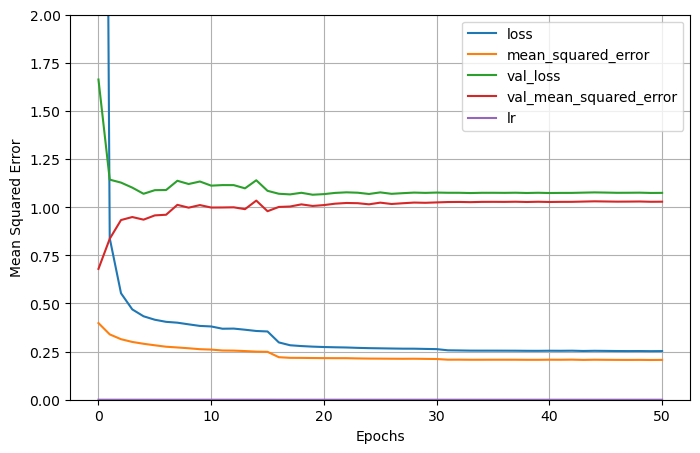

In [14]:
plot_model_history(history)

1/1 [==============================] - 1s 513ms/step


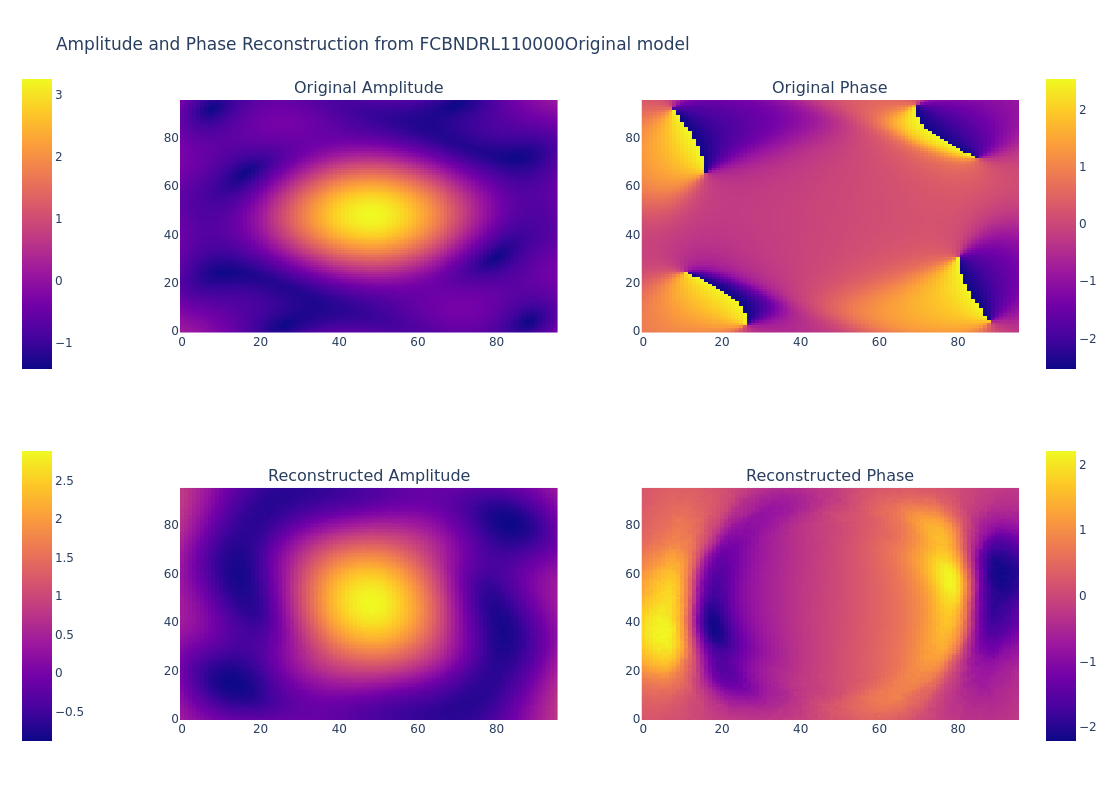

In [15]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    validation_fluxes_array[n],
    validation_amp_phase_array[n][0],
    validation_amp_phase_array[n][1]
    )

1/1 [==============================] - 0s 62ms/step


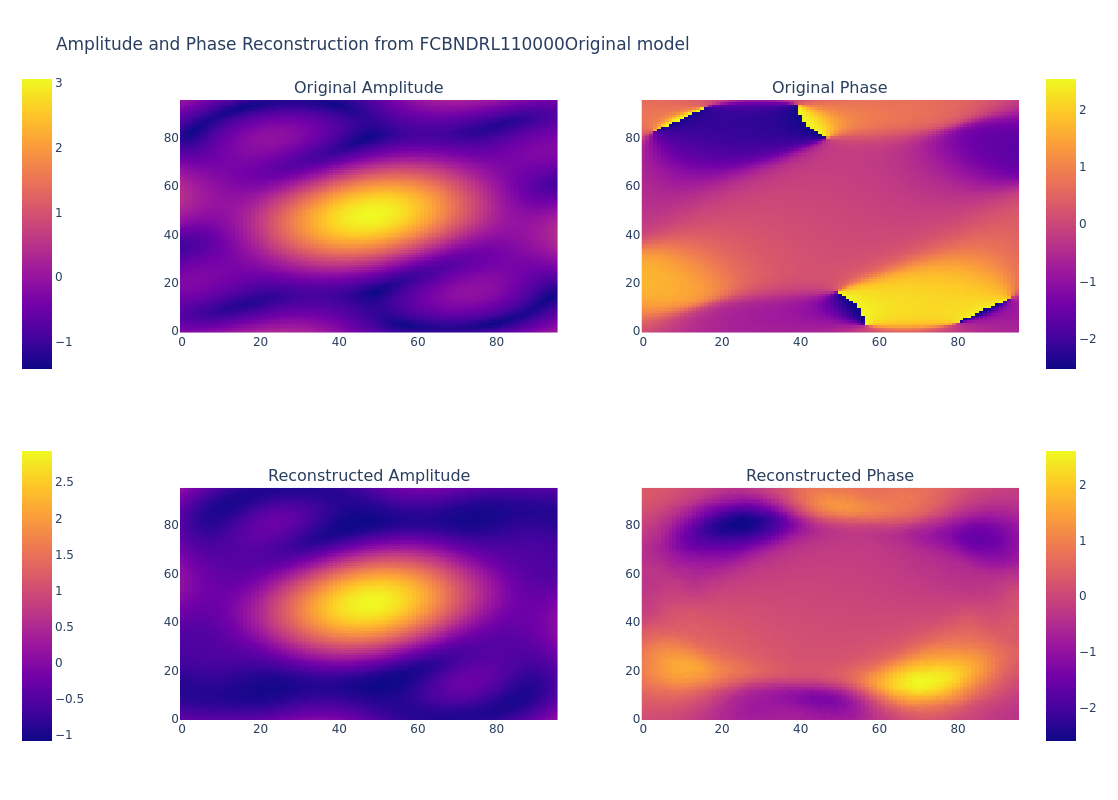

In [16]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    train_fluxes_array[n],
    train_amp_phase_array[n][0],
    train_amp_phase_array[n][1]
    )

In [17]:
store_model(model,
            model.name,
            model_configuration.get_description(),
            history.history['mean_squared_error'][-1],
            history.history['val_mean_squared_error'][-1])